In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import math
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv


In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense
from tensorflow.keras.optimizers import SGD

2024-05-09 09:29:39.193782: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 09:29:39.193937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 09:29:39.327199: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
%pip install -U kaleido

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 17.1 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import pacf,acf
from statsmodels.tsa.arima.model import ARIMA

In [6]:
df1  =  pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
df1.head(10)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1
6,2011-02-04,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1,0,0
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1,1,1
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1
9,2011-02-07,11102,Monday,3,2,2011,d_10,NaN,NaN,NaN,NaN,1,1,0


In [7]:
df2 = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv')
df2.head(10)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
5,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,0,0,1,0,0,5,2,0
6,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,0,0,0,1,0,1,1,0
7,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,12,15,0,0,...,7,0,6,0,15,5,4,1,40,32
8,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,2,0,7,3,...,1,0,0,0,0,0,0,0,1,0
9,HOBBIES_1_010_CA_1_evaluation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,0,0,1,0,...,0,0,1,0,2,1,1,0,0,1


In [8]:
df_final  = df2[(df2['item_id']=='HOBBIES_1_001') & (df2['store_id']=='CA_1')]
df_final = df_final.drop(columns = ['id','item_id','dept_id','cat_id','store_id','state_id'])
df_final = pd.melt(df_final,var_name = 'd',value_name = 'unit_sales')
df_final

,d,unit_sales
0,d_1,0
1,d_2,0
2,d_3,0
3,d_4,0
4,d_5,0
...,...,...
1936,d_1937,0
1937,d_1938,3
1938,d_1939,3
1939,d_1940,0


In [9]:
fig1 = px.line(df_final,x = df_final.index,y = 'unit_sales', title  = 'Sales vs Day')
fig1.update_layout(xaxis_title = 'Day',yaxis_title = 'Unit Sales',legend_title = 'Sales vs Day')
fig1.show()

In [10]:
df_final = df_final.iloc[916:,]
df_final

,d,unit_sales
916,d_917,2
917,d_918,0
918,d_919,1
919,d_920,1
920,d_921,0
...,...,...
1936,d_1937,0
1937,d_1938,3
1938,d_1939,3
1939,d_1940,0


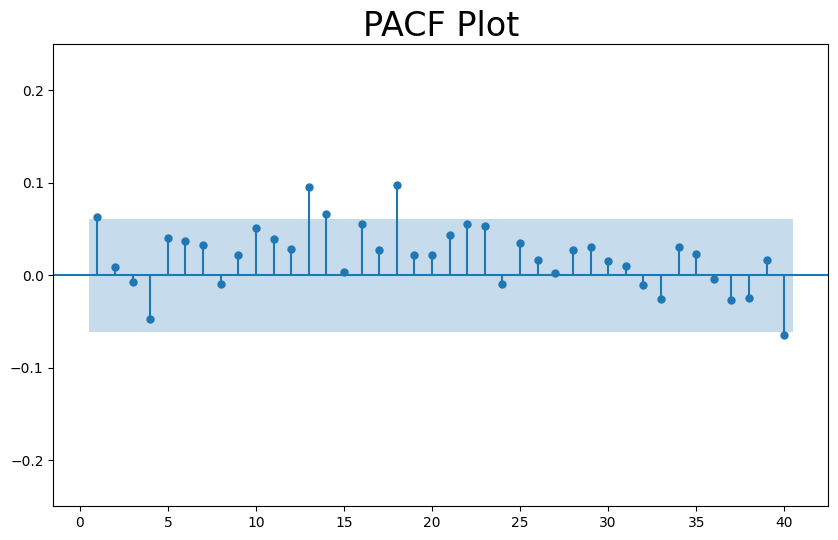

In [11]:
X1 = df_final['unit_sales'].values
lags = 40
acf_fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(X1, lags=lags, zero  = False, ax=ax)
ax.set_title("PACF Plot", size=24)
ax.set_ylim(-0.25, 0.25)
plt.show()

In [12]:
pacf_values, conf_int = pacf(X1, nlags = 40, alpha = 0.05)
# now setting the significanc level (e.g. 0.05 for 95% confidence interval) generally we take this only
significant_lags_pacf1 = np.where(np.abs(pacf_values)> 0.05)[0]
significant_lags_pacf = significant_lags_pacf1[1:]
significant_lags_pacf

array([ 1, 10, 13, 14, 16, 18, 22, 23, 40])

In [13]:
lagged_data = pd.concat([df_final['unit_sales'].shift(lag) for lag in range (1,max(significant_lags_pacf)+1)], axis = 1)
lagged_data.columns = [f'Lag_{lag}' for lag in range (1,max(significant_lags_pacf)+1)]
lagged_data_dropped = lagged_data.dropna()
lagged_data_dropped

,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,...,Lag_31,Lag_32,Lag_33,Lag_34,Lag_35,Lag_36,Lag_37,Lag_38,Lag_39,Lag_40
956,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0
957,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,2.0,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
958,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,...,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
959,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
960,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,0.0,0.0,0.0,4.0,2.0,0.0,1.0,2.0,2.0,1.0,...,0.0,3.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0
1937,0.0,0.0,0.0,0.0,4.0,2.0,0.0,1.0,2.0,2.0,...,1.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0
1938,3.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,1.0,2.0,...,1.0,1.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,2.0
1939,3.0,3.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,1.0,...,1.0,1.0,1.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0


In [14]:
df_output1 = lagged_data_dropped[[f'Lag_{lag}' for lag in significant_lags_pacf]]
df_output1

,Lag_1,Lag_10,Lag_13,Lag_14,Lag_16,Lag_18,Lag_22,Lag_23,Lag_40
956,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0
957,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
958,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
959,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
960,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1936,0.0,1.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0
1937,0.0,2.0,0.0,1.0,0.0,5.0,0.0,0.0,1.0
1938,3.0,2.0,2.0,0.0,1.0,0.0,2.0,0.0,2.0
1939,3.0,1.0,1.0,2.0,1.0,0.0,0.0,2.0,0.0


In [15]:
X = df_output1
y = df_final['unit_sales'].iloc[30:,]
T = X.shape[1]

In [16]:
X = X.to_numpy()
X = X.reshape(X.shape[0],X.shape[1],1)
a = math.trunc(len(X)*0.6)
b = math.trunc(len(X)*0.2)
c = math.trunc(len(X)*0.2)
X_train = X[0:a]
y_train = y[0:a]
X_val = X[a:a+b]
y_val = y[a:a+b]
X_test = X[a+b:a+b+c]
y_test = y[a+b:a+b+c]

In [17]:
Horizon = 1 # the number of variables u want to predict.
model  = Sequential()
model.add(SimpleRNN(100,return_sequences= True,input_shape = (T,1)))
model.add(SimpleRNN(100))
model.add(Dense(Horizon))
model.compile(optimizer = 'RMSprop', loss = 'mse')
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 9, 100)         │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,401 (118.75 KB)

 Trainable params: 30,401 (118.75 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.fit(X_train,y_train, validation_data = (X_val,y_val),epochs = 100)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.8015 - val_loss: 0.1247
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1260 - val_loss: 0.1942
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1539 - val_loss: 0.2424
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1550 - val_loss: 0.1123
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0947 - val_loss: 0.2849
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1328 - val_loss: 0.1037
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0707 - val_loss: 0.1754
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1164 - val_loss: 0.0377
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0443 - val_loss: 0.2292
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1206 - val_loss: 0.0177
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0270 - val_loss: 0.1419
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 

In [19]:
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)
y_val_predicted = model.predict(X_val)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


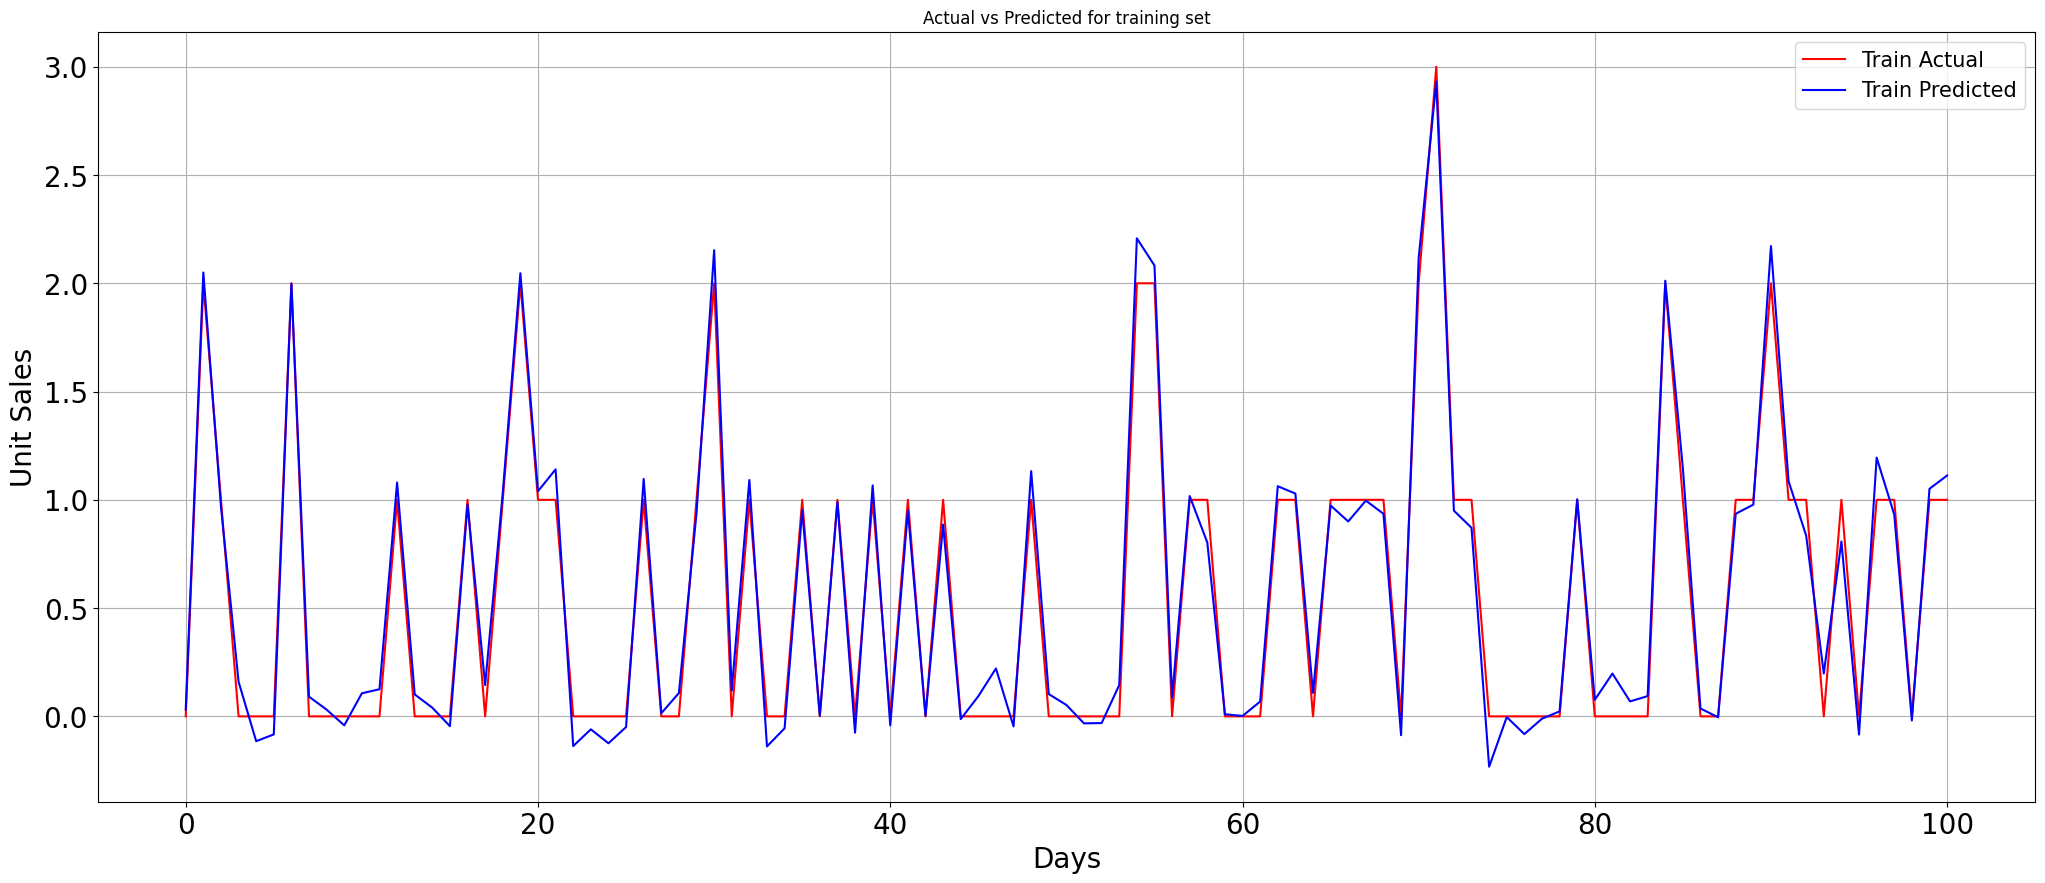

In [20]:
len_train = range(len(X_train))
fig1 = plt.subplots(figsize = (25,10))
plt.plot(len_train[:101],y_train[:101], label = 'Train Actual',color = 'red')
plt.plot(len_train[:101],y_train_predicted[:101], label = 'Train Predicted',color = 'blue')
plt.xlabel('Days',fontsize = 20)
plt.ylabel('Unit Sales',fontsize = 20)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize = '15')
plt.xticks(fontsize = '20')
plt.yticks(fontsize = '20')
plt.title('Actual vs Predicted for training set')
plt.show()

In [21]:
print("MAE: ",mean_absolute_error(y_train,y_train_predicted))
print("MSE: ",mean_squared_error(y_train,y_train_predicted))
print("RMSE: ",math.sqrt(mean_squared_error(y_train,y_train_predicted)))

MAE:  0.08071430680198617
MSE:  0.010988226018085679
RMSE:  0.10482473953263934


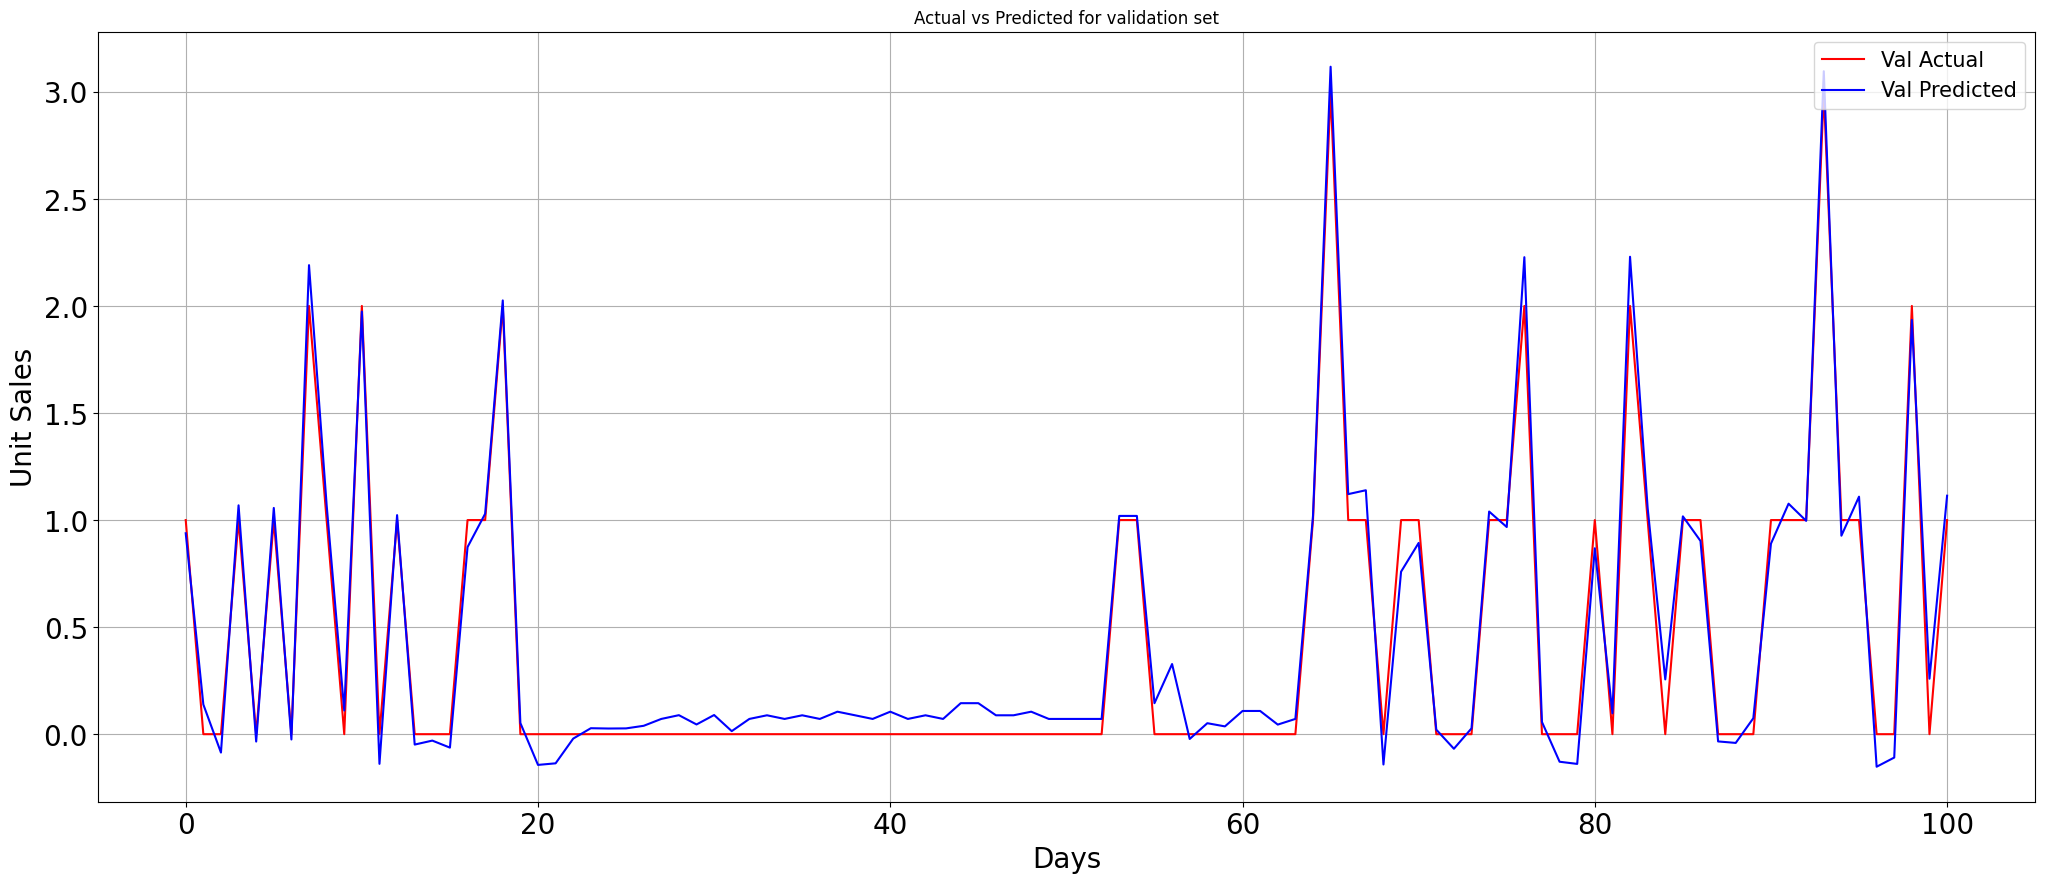

In [22]:
len_val = range(len(X_val))
fig2 = plt.subplots(figsize = (25,10))
plt.plot(len_val[:101],y_val[:101], label = 'Val Actual',color = 'red')
plt.plot(len_val[:101],y_val_predicted[:101], label = 'Val Predicted',color = 'blue')
plt.xlabel('Days',fontsize = 20)
plt.ylabel('Unit Sales',fontsize = 20)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize = 15)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Actual vs Predicted for validation set')
plt.show()

In [23]:
print("MAE: ",mean_absolute_error(y_val,y_val_predicted))
print("MSE: ",mean_squared_error(y_val,y_val_predicted))
print("RMSE: ",math.sqrt(mean_squared_error(y_val,y_val_predicted)))

MAE:  0.08711614456916521
MSE:  0.011913188638377495
RMSE:  0.10914755443150109


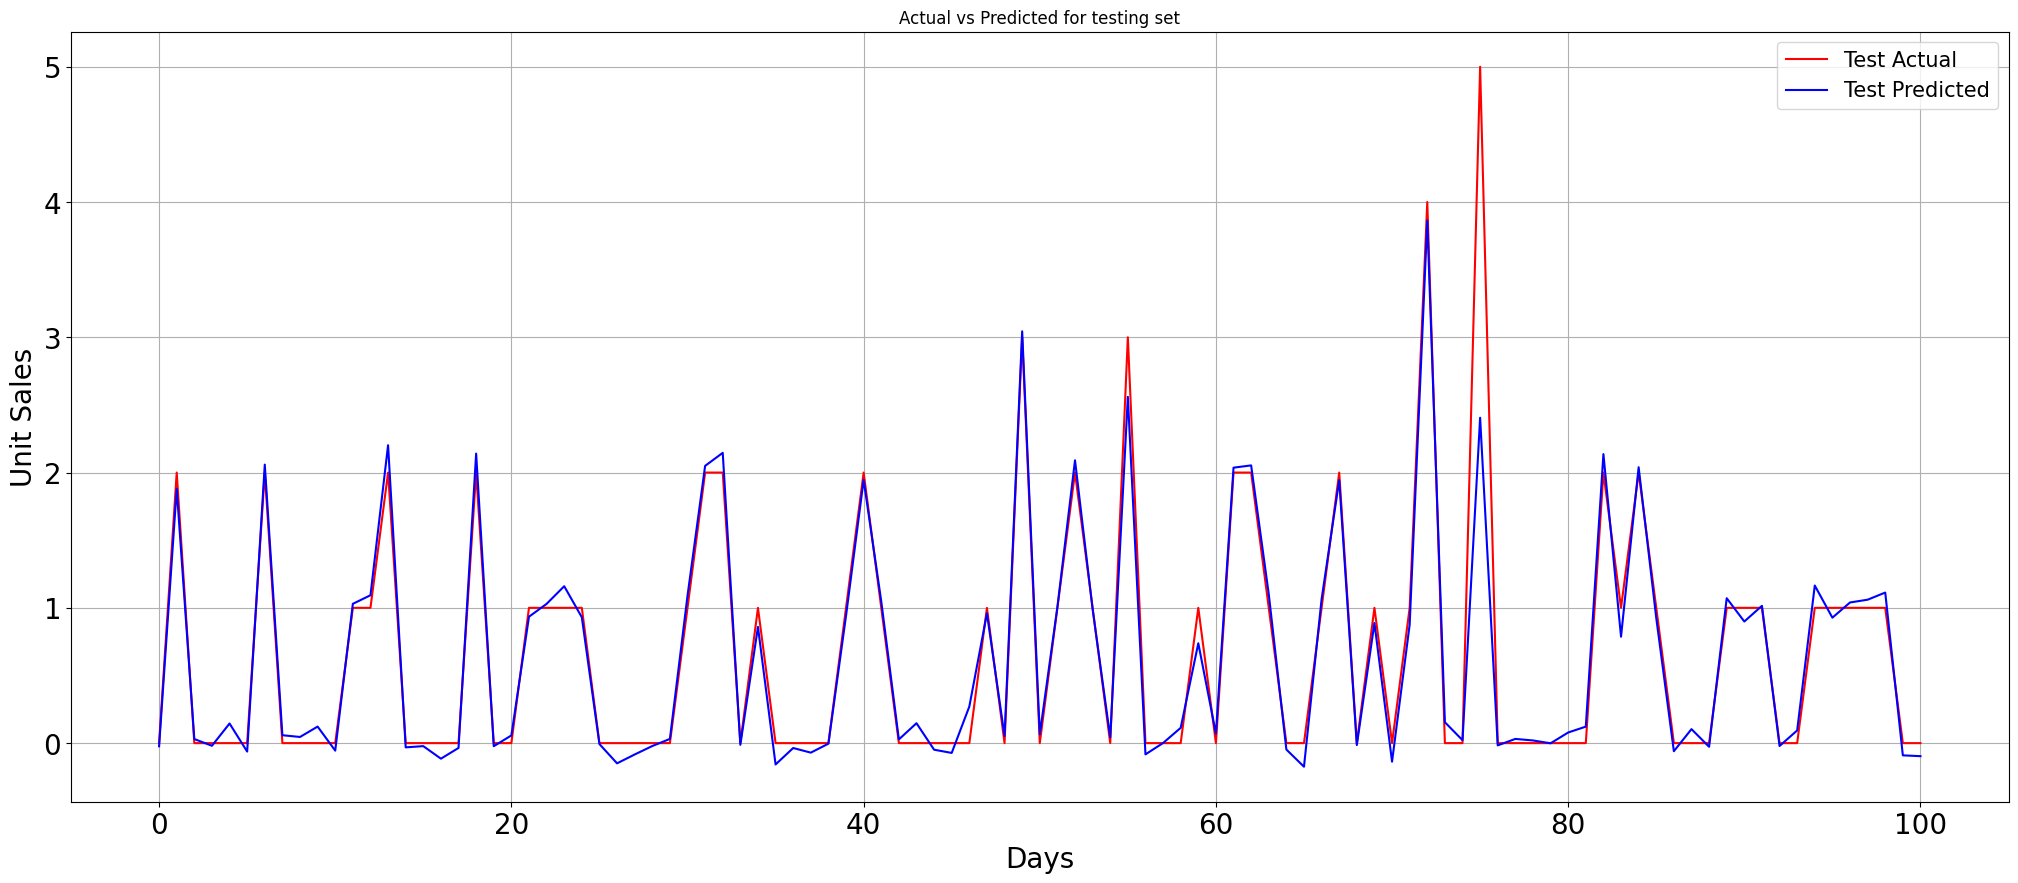

<Figure size 640x480 with 0 Axes>

In [24]:
len_test = range(len(X_test))
fig2 = plt.subplots(figsize = (25,10))
plt.plot(len_test[:101],y_test[:101], label = 'Test Actual',color = 'red')
plt.plot(len_test[:101],y_test_predicted[:101], label = 'Test Predicted',color = 'blue')
plt.xlabel('Days',fontsize = 20)
plt.ylabel('Unit Sales',fontsize = 20)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize = '15')
plt.xticks(fontsize = '20')
plt.yticks(fontsize = '20')
plt.title('Actual vs Predicted for testing set')
plt.show()
plt.savefig('M5_RNN_testing.png')

In [25]:
print("MAE: ",mean_absolute_error(y_test,y_test_predicted))
print("MSE: ",mean_squared_error(y_test,y_test_predicted))
print("RMSE: ",math.sqrt(mean_squared_error(y_test,y_test_predicted)))

MAE:  0.1392503227603617
MSE:  0.07433931181262107
RMSE:  0.27265236439946944


In [26]:
df_new_plot_test = pd.DataFrame({'Time':list(range(101)),'Output_Actual':y_test[:101].to_numpy(),'Output_Predicted':y_test_predicted[:101].reshape(101,)})
fig3 = px.line(df_new_plot_test,x = 'Time',y = ['Output_Actual','Output_Predicted'],title = 'Sales vs Days')
fig3.update_layout(xaxis_title = 'Days',yaxis_title = 'Sales')
fig3.show()
fig3.write_image('M5_RNN_Testing1.png')

# LSTM Univariate

In [27]:
model1 = Sequential()
model1.add(LSTM(100, input_shape = (T,1),return_sequences = True))# 1 is set because we want to predict one variable only
model1.add(LSTM(100))
model1.add(Dense(Horizon))
model1.compile(optimizer = 'RMSprop',loss = 'mse')
model1.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 9, 100)         │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model1.fit(X_train,y_train,validation_data = (X_val,y_val),epochs = 100)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.8817 - val_loss: 0.4776
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6019 - val_loss: 0.4656
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4706 - val_loss: 0.5234
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.5803 - val_loss: 0.4826
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.5402 - val_loss: 0.4478
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4838 - val_loss: 0.4531
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4843 - val_loss: 0.4651
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.4898 - val_loss: 0.5684
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.5328 - val_loss: 0.4473
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.5496 - val_loss: 0.4425
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.5793 - val_loss: 0.4480
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

In [29]:
y_train_predicted1 = model1.predict(X_train)
y_test_predicted1 = model1.predict(X_test)
y_val_predicted1 = model1.predict(X_val)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


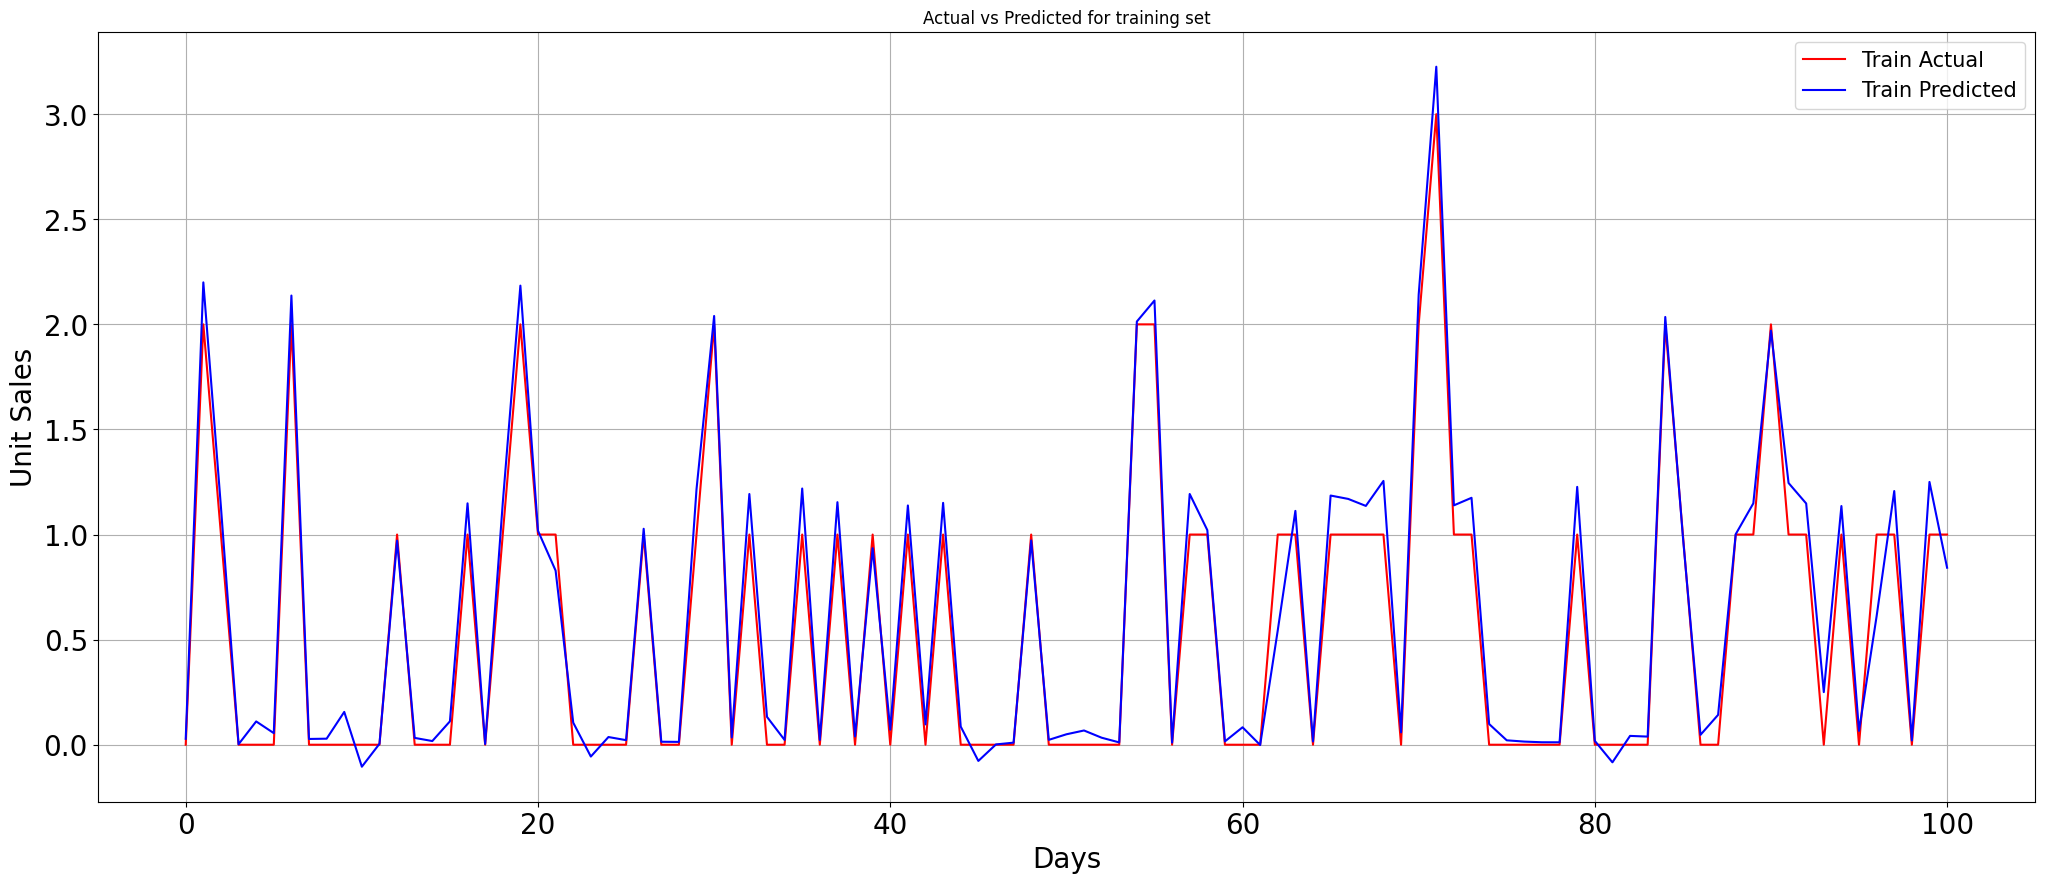

In [30]:
len_train = range(len(X_train))
fig1 = plt.subplots(figsize = (25,10))
plt.plot(len_train[:101],y_train[:101], label = 'Train Actual',color = 'red')
plt.plot(len_train[:101],y_train_predicted1[:101], label = 'Train Predicted',color = 'blue')
plt.xlabel('Days',fontsize = 20)
plt.ylabel('Unit Sales',fontsize = 20)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize = '15')
plt.xticks(fontsize = '20')
plt.yticks(fontsize = '20')
plt.title('Actual vs Predicted for training set')
plt.show()

In [31]:
print("MAE: ",mean_absolute_error(y_train,y_train_predicted1))
print("MSE: ",mean_squared_error(y_train,y_train_predicted1))
print("RMSE: ",math.sqrt(mean_squared_error(y_train,y_train_predicted1)))

MAE:  0.09894276439651922
MSE:  0.018692641833788295
RMSE:  0.13672103654444803


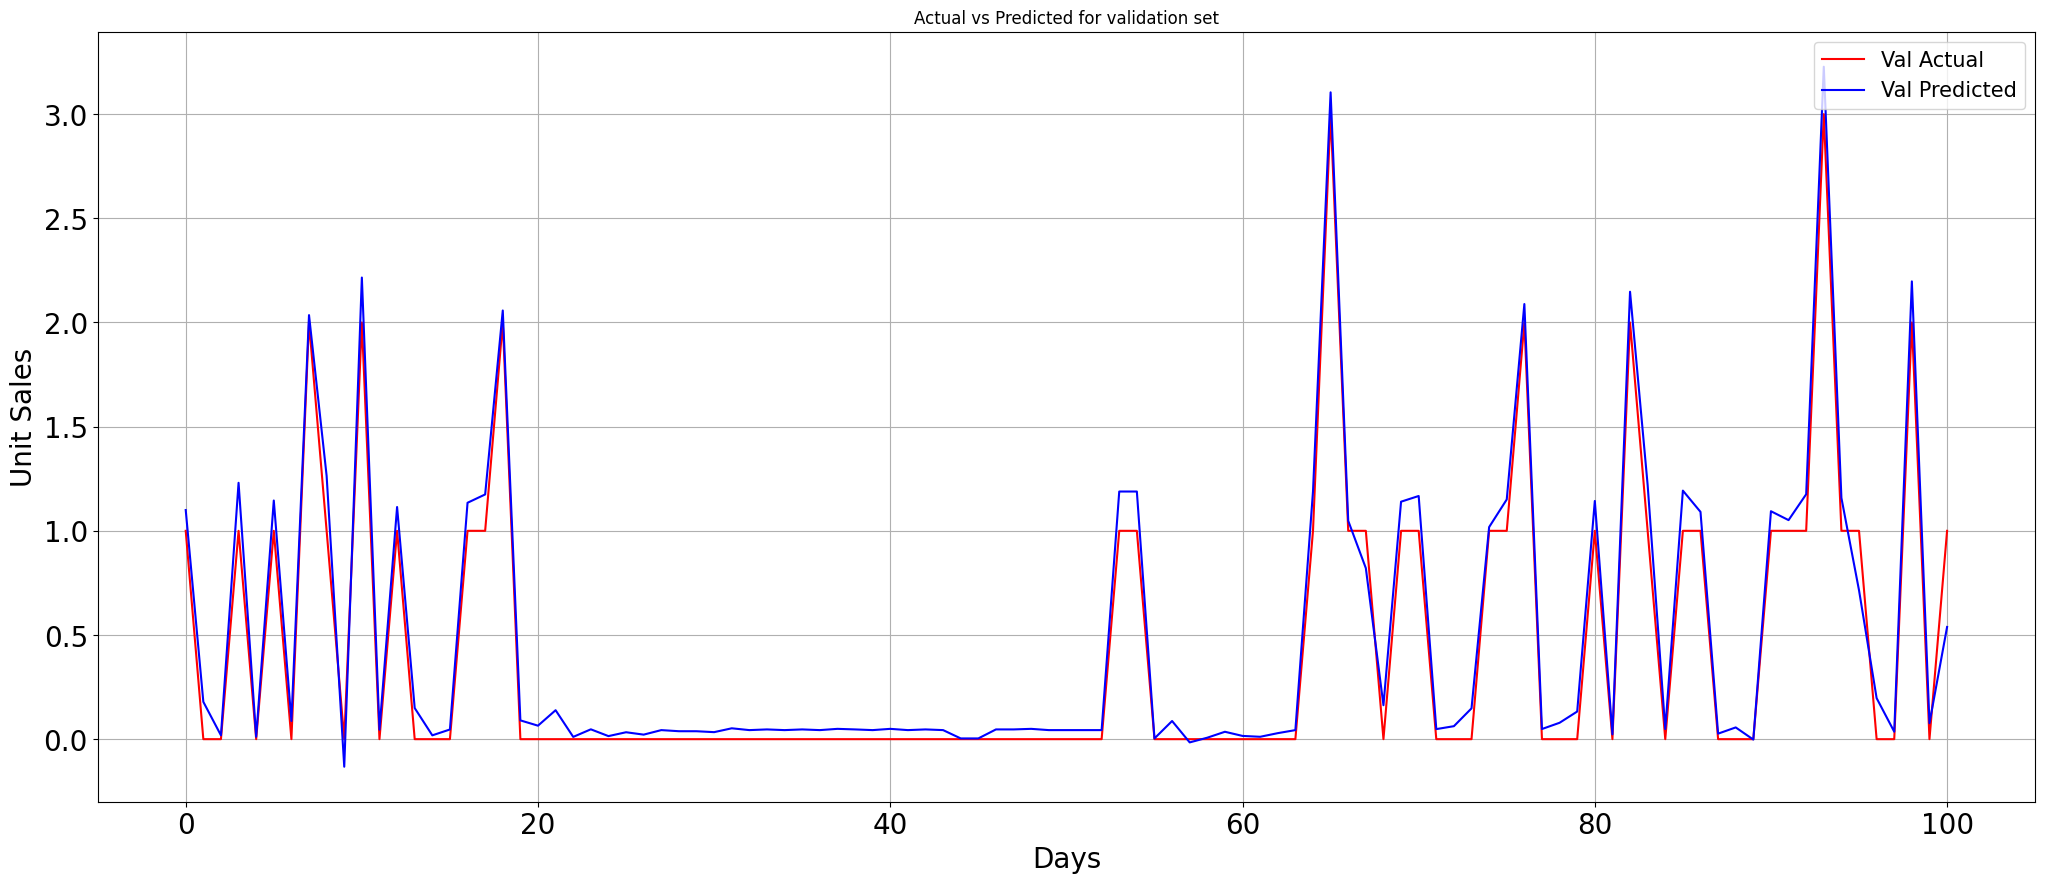

In [32]:
len_val = range(len(X_val))
fig2 = plt.subplots(figsize = (25,10))
plt.plot(len_val[:101],y_val[:101], label = 'Val Actual',color = 'red')
plt.plot(len_val[:101],y_val_predicted1[:101], label = 'Val Predicted',color = 'blue')
plt.xlabel('Days',fontsize = 20)
plt.ylabel('Unit Sales',fontsize = 20)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize = 15)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Actual vs Predicted for validation set')
plt.show()

In [33]:
print("MAE: ",mean_absolute_error(y_val,y_val_predicted1))
print("MSE: ",mean_squared_error(y_val,y_val_predicted1))
print("RMSE: ",math.sqrt(mean_squared_error(y_val,y_val_predicted1)))

MAE:  0.10670425113158177
MSE:  0.022144521811515345
RMSE:  0.14881035518913105


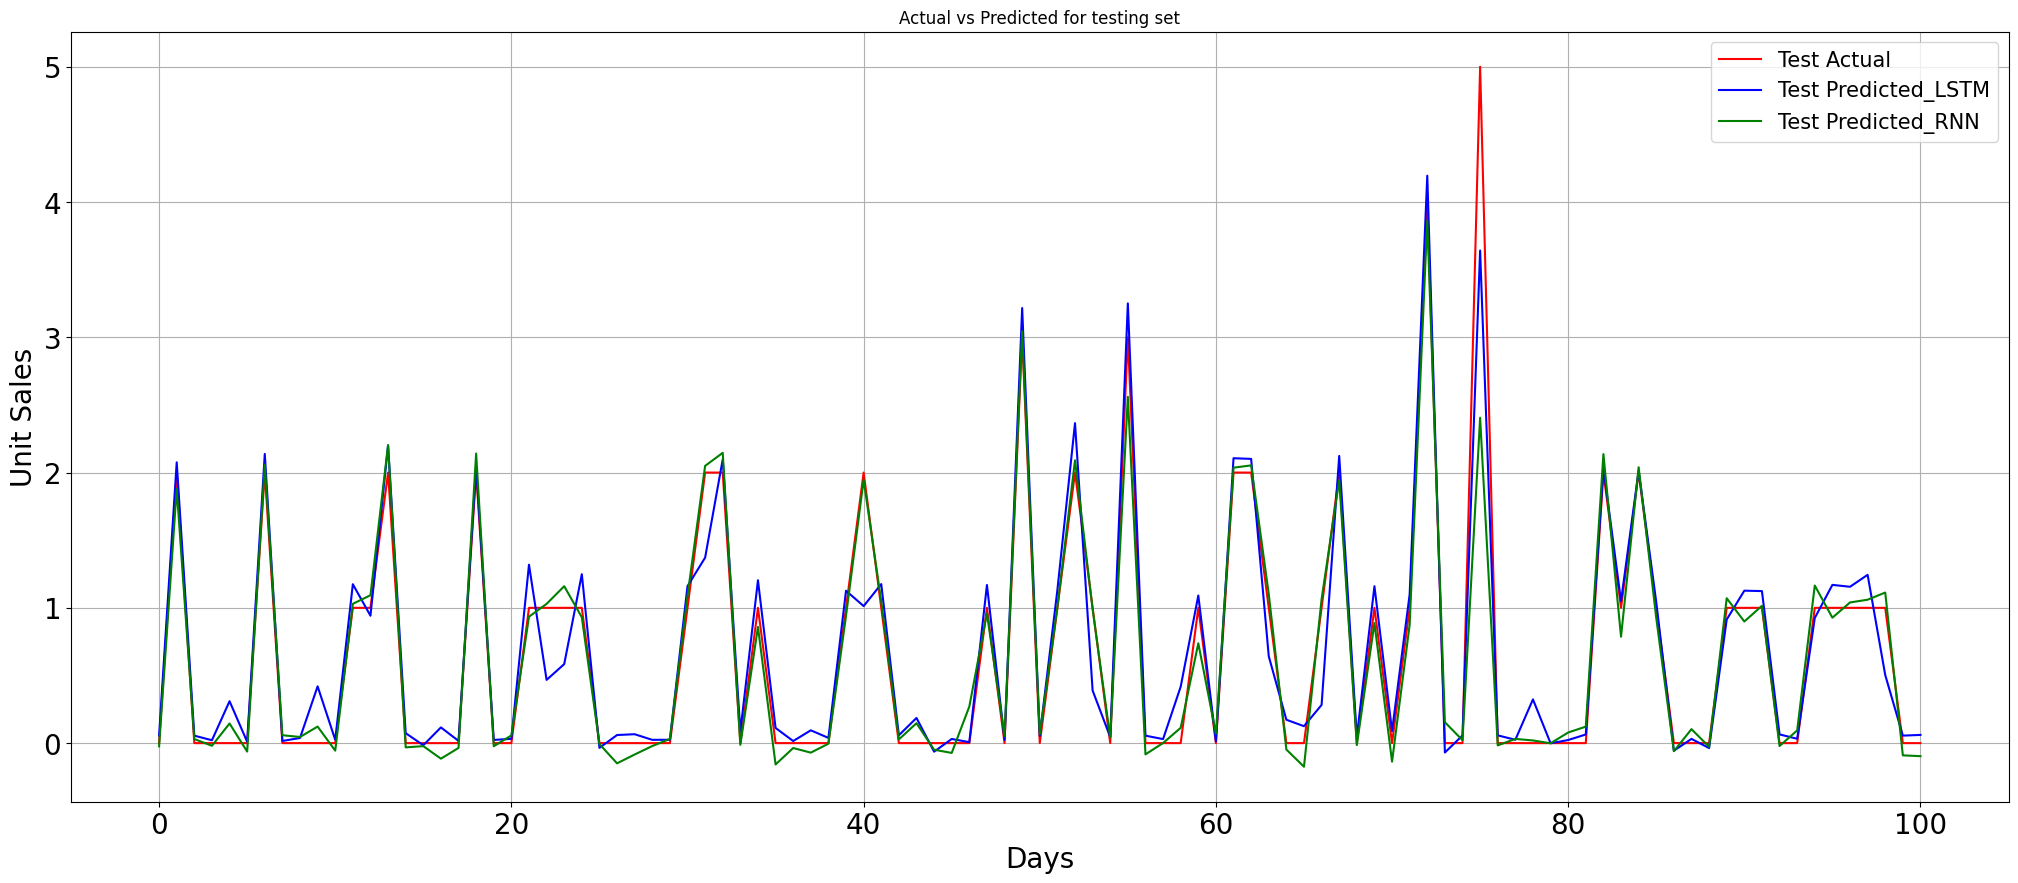

<Figure size 640x480 with 0 Axes>

In [38]:
len_test = range(len(X_test))
fig2 = plt.subplots(figsize = (25,10))
plt.plot(len_test[:101],y_test[:101], label = 'Test Actual',color = 'red')
plt.plot(len_test[:101],y_test_predicted1[:101], label = 'Test Predicted_LSTM',color = 'blue')
plt.plot(len_test[:101],y_test_predicted[:101], label = 'Test Predicted_RNN',color = 'green')
plt.xlabel('Days',fontsize = 20)
plt.ylabel('Unit Sales',fontsize = 20)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize = '15')
plt.xticks(fontsize = '20')
plt.yticks(fontsize = '20')
plt.title('Actual vs Predicted for testing set')
plt.show()
plt.savefig('M5_LSTM_testing.jpg')

In [35]:
print("MAE: ",mean_absolute_error(y_test,y_test_predicted1))
print("MSE: ",mean_squared_error(y_test,y_test_predicted1))
print("RMSE: ",math.sqrt(mean_squared_error(y_test,y_test_predicted1)))

MAE:  0.20591994015698506
MSE:  0.1563080075038523
RMSE:  0.39535807504571385


In [36]:
df_new_plot_test1 = pd.DataFrame({'Time':list(range(101)),'Output_Actual':y_test[:101].to_numpy(),'Output_Predicted':y_test_predicted1[:101].reshape(101,)})
fig3 = px.line(df_new_plot_test1,x = 'Time',y = ['Output_Actual','Output_Predicted'],title = 'Sales vs Days')
fig3.update_layout(xaxis_title = 'Days',yaxis_title = 'Sales')
fig3.show()
fig3.write_image('M5_LSTM_Testing1.png')